In [1]:
import numpy as np
import matplotlib.pyplot as plt

We are studying the problem of determining the coefficients of a polynomial 
$$p(t)=c_0+c_1t+\dotsc + c_n t^n,$$ 
given its values in $m+1$ distinct points
$$b_0 = p(t_0), b_1=p(t_1), \dotsc, b_m=p(t_m).$$

The problem reduces to solving a linear equation $A\mathbf{c}=\mathbf{b}$
where $A$ is a $(m+1)\times (n+1)$ matrix:

$$A = \begin{bmatrix} 
1 & t_0 & t_0^2 & \dots & t_0^n \\
1 & t_1 & \ddots & & \vdots \\
\vdots & \vdots & &\ddots & \vdots \\
1 & t_m & \dots & & t_m^n
\end{bmatrix}
$$

The nature of this equation depends on $m$ and $n$:
 * If $m<n$: Underdetermined, infinitely many solutions
 * If $m=n$: Unique solution, but usually  **ill conditioned.**
 * If $m>n$: Overdetermined. Least squares problem is ill conditioned.
 
The large condition number means that the computed coefficients are extremely sensitive to small perturbations in $\mathbf{b}$.


In [16]:
def poly(c, t):
    # evaluates c[0]+c[1]t+...+c[n]t^n in points given by t.
    return np.polyval(np.flip(c),t)

def mystr(z): #formatting function
    return np.array2string(z, precision=3)
  

In [57]:
n=7
m=7

c=np.random.randn(n+1) #random coefficients
print('c = '+mystr(c))
t = np.linspace(0,1,m+1) #samples uniformly distributed on [0,1]
b=poly(c,t) #evaluate polynomial in sample points

tplot =  np.linspace(-0.1,1.1, 10*m+1) # finer grid for plotting
pplot = poly(c, tplot)

c = [ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]


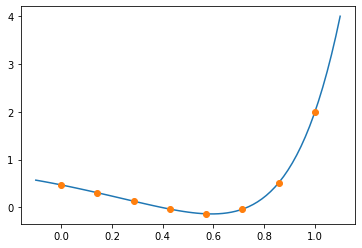

In [58]:
plt.plot( tplot, pplot, t, b, 'o')

In [59]:
A=np.stack(list(t**k for k in range(n+1))).T
s=np.linalg.svd(A, compute_uv=False)
print('Singular values: ' + mystr(s))
print('cond(A) = '+mystr(np.linalg.cond(A)))

Singular values: [3.964e+00 1.805e+00 5.561e-01 1.358e-01 2.618e-02 3.750e-03 3.471e-04
 1.480e-05]
cond(A) = 267816.701


We use np.linalg.lstsq to solve the problem

In [60]:
x0=np.linalg.lstsq(A,b, rcond=None)[0]
print('True solution\t\t c='+mystr(c))
print('Computed solution\t x='+mystr(x0) +'\n')
print('Relative error:' +mystr(np.linalg.norm(x0-c)/np.linalg.norm(c)))

True solution		 c=[ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]
Computed solution	 x=[ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]

Relative error:2.021e-12


Looks pretty good, but what if there is noise in our data?

In [61]:
bp=b+0.01*np.random.randn(m+1) # add random noise
print('Relative change: ' +mystr(np.linalg.norm(bp-b)/np.linalg.norm(b)))

Relative change: 0.013


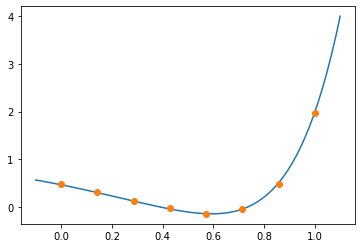

In [62]:
plt.plot( tplot, pplot, t, bp, 'o')

Try to solve it with lstsq

In [64]:
x=np.linalg.lstsq(A,bp, rcond=None)[0]
print('True solution\n c='+mystr(c))
print('Computed solution\n x='+mystr(x))
print('\nRelative error: ' +mystr(np.linalg.norm(x-c)/np.linalg.norm(c)))

True solution
 c=[ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]
Computed solution
 x=[ 4.808e-01  2.912e-01 -2.360e+01  1.360e+02 -3.790e+02  5.489e+02
 -3.947e+02  1.137e+02]

Relative error: 282.881


Relative error in the computed $\mathbf{x}$ is large, but how do the polynomials look?

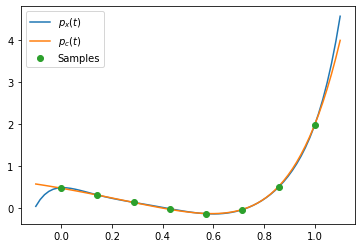

In [65]:
plt.plot(tplot, poly(x, tplot), tplot, pplot, t, bp, 'o')
plt.legend(['$p_x(t)$', '$p_c(t)$', 'Samples'])

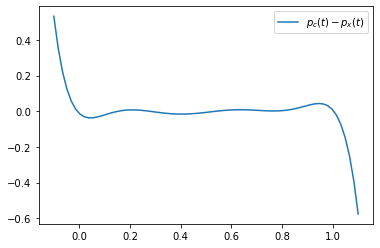

In [73]:
plt.plot(tplot,poly(c-x, tplot))
plt.legend(['$p_c(t)-p_x(t)$'])

In [74]:
def tikhonov(A, b, l):
    u,s,vh=np.linalg.svd(A, full_matrices=False)
    d=s/(s**2+l)
    x=(vh.T*d)@(u.T@b)
    return x

In [75]:
xt=tikhonov(A, b, 1e-4)
xtp=tikhonov(A, bp, 1e-4)
print('Without noise:')
print('True solution\n c='+mystr(c))
print('Computed solution\n x='+mystr(xt) +'\n')
print('Relative error: ' +mystr(np.linalg.norm(xt-c)/np.linalg.norm(c)))

print('\n\nWith noise:')
print('True solution\n c='+mystr(c))
print('Computed solution\n xp='+mystr(xtp) +'\n')
print('Relative error: ' +mystr(np.linalg.norm(xtp-c)/np.linalg.norm(c)))

print('\nRelative change in solution: '+ mystr(np.linalg.norm(xtp-xt)/np.linalg.norm(xt)))

Without noise:
True solution
 c=[ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]
Computed solution
 x=[ 0.469 -1.091 -0.439  0.123  0.472  0.69   0.832  0.932]

Relative error: 0.711


With noise:
True solution
 c=[ 0.469 -1.07  -0.64   0.838 -0.801  1.897  0.251  1.044]
Computed solution
 xp=[ 0.479 -1.153 -0.227 -0.033  0.329  0.673  0.9    1.012]

Relative error: 0.725

Relative change in solution: 0.165


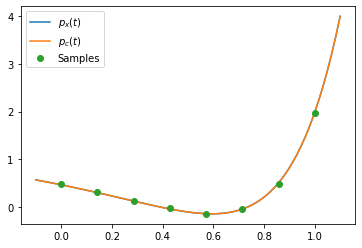

In [76]:
plt.plot(tplot, poly(xt, tplot), tplot, pplot, t, bp, 'o')
plt.legend(['$p_x(t)$', '$p_c(t)$', 'Samples'])

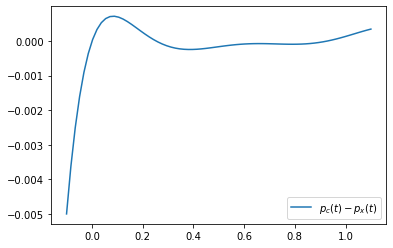

In [78]:
plt.plot(tplot,poly(c-xt, tplot))
plt.legend(['$p_c(t)-p_x(t)$'])

# Tikhonov vs Min-norm Least squares 

As shown in the lecture, in Tikhonov regularization, we 'approximate' $\frac{1}{\sigma}$ with $\frac{\sigma}{\sigma^2+\alpha}$. Here is a plot of the two functions

C:\NMBU\TEMP/ipykernel_8728/177869755.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ssinv=1/ss


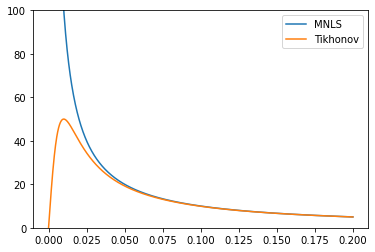

In [84]:
alpha=1e-4

ss=np.linspace(0,0.2,1000)
ssinv=1/ss
#ssinv[0]=0
sstikh = ss/(ss**2+alpha)
plt.plot(ss, ssinv, ss, sstikh)
plt.ylim(0, alpha**-.5)
plt.legend(['MNLS', 'Tikhonov'])